In [71]:
from collections import defaultdict
from itertools import product

import json
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import pickle
import seaborn as sns
import time
import warnings

import condo

In [2]:
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('font', size=7) #controls default text size
plt.rc('axes', titlesize=7) #fontsize of the title
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('legend', fontsize=7) #fontsize of the legend
plt.ioff();

In [3]:
N_T = 200
N_S = 100

# How batch effect affects S
batch_m = 2
batch_b = 5

# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

noise_settings = ["NoiseFree", "Noisy",]
targetshift_settings = ["TargetShift", "NoTargetShift",]
featureshift_settings = ["FeatureShift", "NoFeatureShift"]

prob_settings = ["Homoscedastic Linear", "Heteroscedastic Linear", "Nonlinear"]
#prob_settings = ["Nonlinear"]
num_probs = len(prob_settings)

rMSEs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
rMSEs_test = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
num_random = 1
for rix in range(num_random):
    rng = np.random.RandomState(rix)
    for setting_combo in product(noise_settings, targetshift_settings, featureshift_settings):
        (noise_setting, targetshift_setting, featureshift_setting) = setting_combo
        setting_str = "-".join(setting_combo)
        assert noise_setting in ("Noisy", "NoiseFree")
        assert targetshift_setting in ("NoTargetShift", "TargetShift")
        assert featureshift_setting in ("NoFeatureShift", "FeatureShift")

        fig, axes = plt.subplots(
            nrows=7, ncols=num_probs, sharex="all", sharey="all", squeeze=False,
            gridspec_kw={"hspace": 0.03, "wspace": 0.03},
            figsize=(6, 10), dpi=150)
        msize = 1
        basic_leg = ['target', 'source: batch-effected', 'source: true (unobserved)']
        figname = f"figure-continuous1d-{setting_str}-{rix}.pdf"
        fsizemse = 7

        for pix, prob_setting in enumerate(prob_settings):
            print(f"rix:{rix} {setting_str} {prob_setting}")
            # Distribution of confounders
            X_T = np.sort(rng.uniform(0, 8, size=(N_T,)))
            if targetshift_setting == "TargetShift":
                X_S = np.sort(rng.uniform(4, 8, size=(N_S,)))
                X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))
            elif targetshift_setting == "NoTargetShift":
                X_S = np.sort(rng.uniform(0, 8, size=(N_S,)))
                X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))

            if prob_setting == "Homoscedastic Linear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 0
                phi_b = 2
                mu_T = theta_m * X_T + theta_b
                mu_S = theta_m * X_S + theta_b
                mu_S_test = theta_m * X_S_test + theta_b
                sigma_T = phi_m * X_T + phi_b
                sigma_S = phi_m * X_S + phi_b
                sigma_S_test = phi_m * X_S_test + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            elif prob_setting == "Heteroscedastic Linear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 1
                phi_b = 1
                mu_T = theta_m * X_T + theta_b
                mu_S = theta_m * X_S + theta_b
                mu_S_test = theta_m * X_S_test + theta_b
                sigma_T = phi_m * X_T + phi_b
                sigma_S = phi_m * X_S + phi_b
                sigma_S_test = phi_m * X_S_test + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            elif prob_setting == "Nonlinear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 1
                phi_b = 1
                mu_T = theta_m * (np.maximum(X_T-5, 0) ** 2) + theta_b
                mu_S = theta_m * (np.maximum(X_S-5, 0) ** 2) + theta_b
                mu_S_test = theta_m * (np.maximum(X_S_test-5, 0) ** 2) + theta_b
                sigma_T = phi_m * (np.maximum(X_T-5, 0) ** 2) + phi_b
                sigma_S = phi_m * (np.maximum(X_S-5, 0) ** 2) + phi_b
                sigma_S_test = phi_m * (np.maximum(X_S_test-5, 0) ** 2) + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            if featureshift_setting == "FeatureShift":
                Sbatch = batch_m * Strue + batch_b
                Sbatch_test = batch_m * Strue_test + batch_b
                oracle_m = true_m
                oracle_b = true_b
            elif featureshift_setting == "NoFeatureShift":
                oracle_m = 1.0
                oracle_b = 0.0
                Sbatch = Strue.copy()
                Sbatch_test = Strue_test.copy()

            if noise_setting == "NoiseFree":
                pass
            elif noise_setting == "Noisy":
                Sbatch = Sbatch + rng.normal(0, 1, size=(N_S,))
                Sbatch_test = Sbatch_test + rng.normal(0, 1, size=(N_S,))

            T_ = T.reshape(-1, 1) # (N_T, 1)
            Strue_ = Strue.reshape(-1, 1) # (N_S, 1)
            Sbatch_ = Sbatch.reshape(-1, 1)
            X_T_ = X_T.reshape(-1, 1) # (N_T, 1)
            X_S_ = X_S.reshape(-1, 1)
            Strue_test_ = Strue_test.reshape(-1, 1) # (N_S, 1)
            Sbatch_test_ = Sbatch_test.reshape(-1, 1)
            X_S_test_ = X_S_test.reshape(-1, 1)
            
            # Before correction
            method = "Before Correction"
            rMSE = np.sqrt(np.mean((Sbatch - Strue) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sbatch_test - Strue_test) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[0, pix].tick_params(axis="both", which="both", direction="in")    
            axes[0, pix].scatter(X_T, T, s=msize)
            axes[0, pix].scatter(X_S, Sbatch, s=msize)
            axes[0, pix].scatter(X_S, Strue, s=msize)
            axes[0, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[0, pix].transAxes);
            if pix == num_probs - 1:
                axes[0, pix].legend(
                    basic_leg,
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # Oracle - not displayed
            method = "Oracle"
            Soracle = oracle_m * Sbatch + oracle_b
            Soracle_test = oracle_m * Sbatch_test + oracle_b
            rMSE = np.sqrt(np.mean((Soracle - Strue) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Soracle_test - Strue_test) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")

            # OTDA
            method = "Gaussian OT"
            A_otda, b_otda = ot.da.OT_mapping_linear(Sbatch_, T_)
            Sotda_ = Sbatch_.dot(A_otda) + b_otda
            Sotda_test_ = Sbatch_test_.dot(A_otda) + b_otda
            rMSE = np.sqrt(np.mean((Sotda_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sotda_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[1, pix].tick_params(axis="both", which="both", direction="in")    
            axes[1, pix].scatter(X_T, T, s=msize)
            axes[1, pix].scatter(X_S, Sbatch, s=msize)
            axes[1, pix].scatter(X_S, Strue, s=msize)
            axes[1, pix].scatter(X_S, Sotda_, s=msize)
            axes[1, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[1, pix].transAxes);
            if pix == num_probs - 1:
                axes[1, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # MMD
            method = "MMD"
            mmd_alpha = 0.01
            if prob_setting == "Nonlinear":
                mmd_alpha = 0.1
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.MMDAdapter(
                    transform_type="location-scale",
                    optim_kwargs={"epochs": 25, "alpha": mmd_alpha, "beta": 0.9},
                    debug=False,
                    verbose=0,
                )
                cder.fit(Sbatch_, T_)
                Smmd_ = cder.transform(Sbatch_)
                Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[2, pix].tick_params(axis="both", which="both", direction="in")    
            axes[2, pix].scatter(X_T, T, s=msize)
            axes[2, pix].scatter(X_S, Sbatch, s=msize)
            axes[2, pix].scatter(X_S, Strue, s=msize)
            axes[2, pix].scatter(X_S, Smmd_, s=msize)
            axes[2, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[2, pix].transAxes);
            if pix == num_probs - 1:
                axes[2, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # ConDo using ReverseKL with linear Gaussian
            method = "ConDo Linear-ReverseKL"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.ConDoAdapter(
                    sampling="product",
                    transform_type="location-scale",
                    model_type="linear",
                    divergence="reverse",
                    debug=False,
                    verbose=0
                )
                cder.fit(Sbatch_, T_, X_S_, X_T_)
                Sreverse_ = cder.transform(Sbatch_)
                Sreverse_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Sreverse_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sreverse_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[3, pix].tick_params(axis="both", which="both", direction="in")    
            axes[3, pix].scatter(X_T, T, s=msize)
            axes[3, pix].scatter(X_S, Sbatch, s=msize)
            axes[3, pix].scatter(X_S, Strue, s=msize)
            axes[3, pix].scatter(X_S, Sreverse_, s=msize)
            axes[3, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[3, pix].transAxes);
            if pix == num_probs - 1:
                axes[3, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);            

            # ConDo using ReverseKL with heteroscedastic GP
            method = "ConDo GP-ReverseKL"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.ConDoAdapter(
                    sampling="product",
                    transform_type="location-scale",
                    model_type="heteroscedastic-gp",
                    divergence="reverse",
                    debug=False,
                    verbose=0
                )
                cder.fit(Sbatch_, T_, X_S_, X_T_)
                Sreverse_ = cder.transform(Sbatch_)
                Sreverse_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Sreverse_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sreverse_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[4, pix].tick_params(axis="both", which="both", direction="in")    
            axes[4, pix].scatter(X_T, T, s=msize)
            axes[4, pix].scatter(X_S, Sbatch, s=msize)
            axes[4, pix].scatter(X_S, Strue, s=msize)
            axes[4, pix].scatter(X_S, Sreverse_, s=msize)
            axes[4, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[4, pix].transAxes);
            if pix == num_probs - 1:
                axes[4, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # ConDo using ReverseKL with product-of-GMMs
            method = "ConDo PoGMM-ReverseKL"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.ConDoAdapter(
                    sampling="product",
                    transform_type="location-scale",
                    model_type="pogmm",
                    divergence="reverse",
                    debug=False,
                    verbose=0
                )
                cder.fit(Sbatch_, T_, X_S_, X_T_)
                Sreverse_ = cder.transform(Sbatch_)
                Sreverse_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Sreverse_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sreverse_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[5, pix].tick_params(axis="both", which="both", direction="in")    
            axes[5, pix].scatter(X_T, T, s=msize)
            axes[5, pix].scatter(X_S, Sbatch, s=msize)
            axes[5, pix].scatter(X_S, Strue, s=msize)
            axes[5, pix].scatter(X_S, Sreverse_, s=msize)
            axes[5, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[5, pix].transAxes);
            if pix == num_probs - 1:
                axes[5, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # Condo using MMD
            method = "ConDo MMD"
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cder = condo.ConDoAdapter(
                    sampling="product",
                    transform_type="location-scale",
                    model_type="empirical",
                    divergence="mmd",
                    optim_kwargs={"epochs": 0.01, "alpha": 0.01, "beta": 0.9},
                    debug=False,
                    verbose=0,
                )
                cder.fit(Sbatch_, T_, X_S_, X_T_)
                Smmd_ = cder.transform(Sbatch_)
                Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[6, pix].tick_params(axis="both", which="both", direction="in")    
            axes[6, pix].scatter(X_T, T, s=msize)
            axes[6, pix].scatter(X_S, Sbatch, s=msize)
            axes[6, pix].scatter(X_S, Strue, s=msize)
            axes[6, pix].scatter(X_S, Smmd_, s=msize)
            axes[6, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[6, pix].transAxes);
            if pix == num_probs - 1:
                axes[6, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);
        if rix in (0, num_random - 1):
            fig.savefig(figname, bbox_inches="tight")
        plt.close()

rix:0 NoiseFree-TargetShift-FeatureShift Homoscedastic Linear
    Before Correction rMSE: 30.110  (22.992)
    Oracle rMSE: 0.000  (0.000)
    Gaussian OT rMSE: 9.049  (17.721)
    MMD rMSE: 5.340  (3.820)
    ConDo Linear-ReverseKL rMSE: 0.474  (1.236)
    ConDo GP-ReverseKL rMSE: 0.473  (1.234)
    ConDo PoGMM-ReverseKL rMSE: 0.644  (1.132)
    ConDo MMD rMSE: 29.203  (22.313)
rix:0 NoiseFree-TargetShift-FeatureShift Heteroscedastic Linear
    Before Correction rMSE: 31.425  (26.066)
    Oracle rMSE: 0.000  (0.000)
    Gaussian OT rMSE: 8.538  (11.201)
    MMD rMSE: 5.402  (4.365)
    ConDo Linear-ReverseKL rMSE: 0.731  (1.249)
    ConDo GP-ReverseKL rMSE: 1.925  (2.077)
    ConDo PoGMM-ReverseKL rMSE: 0.734  (1.264)
    ConDo MMD rMSE: 30.727  (25.492)
rix:0 NoiseFree-TargetShift-FeatureShift Nonlinear
    Before Correction rMSE: 17.877  (15.738)
    Oracle rMSE: 0.000  (0.000)
    Gaussian OT rMSE: 4.535  (4.148)
    MMD rMSE: 9.344  (8.213)
    ConDo Linear-ReverseKL rMSE: 2.458  

In [23]:
s_dict = {}

for setting_str in rMSEs:
    print(setting_str)
    print(f" & " + " & ".join(prob_settings) + r" \\")
    cur_min = defaultdict(lambda: np.inf)
    cur_min_test = defaultdict(lambda: np.inf)
    cur_max = defaultdict(lambda: np.NINF)
    cur_max_test = defaultdict(lambda: np.NINF)
    for method in rMSEs[setting_str]:
        if method in ('Before Correction', 'Oracle'):
            continue
        method_str = f"{method}"
        for prob_setting in prob_settings:
            cur_rmse = np.mean(rMSEs[setting_str][method][prob_setting])
            cur_rmse_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            cur_min[prob_setting] = min(cur_min[prob_setting], cur_rmse)
            cur_min_test[prob_setting] = min(cur_min_test[prob_setting], cur_rmse)
            cur_max[prob_setting] = max(cur_max[prob_setting], cur_rmse)
            cur_max_test[prob_setting] = max(cur_max_test[prob_setting], cur_rmse)
    method_str_all = r""        
    for method in rMSEs[setting_str]:
        method_str = f"{method}"
        for prob_setting in prob_settings:
            cur_rmse = np.mean(rMSEs[setting_str][method][prob_setting])
            cur_rmse_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            is_min = cur_rmse == cur_min[prob_setting]
            is_max = cur_rmse == cur_max[prob_setting]
            is_min_test = cur_rmse == cur_min_test[prob_setting]
            is_max_test = cur_rmse == cur_max_test[prob_setting]
            mycolor = "black"
            if is_min:
                mycolor = "green"
            if is_max:
                mycolor = "red"
            if method in ('Before Correction', 'Oracle'):
                mycolor = "black"
            mycolortest = "black"
            if is_min_test:
                mycolortest = "green"
            if is_max_test:
                mycolortest = "red"
            if method in ('Before Correction', 'Oracle'):
                mycolortest = "black"
            train_str = " & {\\color{" + mycolor + "}" + f"{cur_rmse:.3f}" + "}"
            test_str = " ({\\color{" + mycolortest + "}" + f"{cur_rmse_test:.3f}" + "})"
            method_str += train_str + test_str
        method_str += r" \\"
        print(method_str)
        method_str_all += method_str
    s_dict[setting_str] = method_str_all

NoiseFree-TargetShift-FeatureShift
 & Homoscedastic Linear & Heteroscedastic Linear & Nonlinear \\
Before Correction & {\color{black}30.110} ({\color{black}22.992}) & {\color{black}31.425} ({\color{black}26.066}) & {\color{black}17.877} ({\color{black}15.738}) \\
Oracle & {\color{black}0.000} ({\color{black}0.000}) & {\color{black}0.000} ({\color{black}0.000}) & {\color{black}0.000} ({\color{black}0.000}) \\
Gaussian OT & {\color{black}9.049} ({\color{black}17.721}) & {\color{black}8.538} ({\color{black}11.201}) & {\color{black}4.535} ({\color{black}4.148}) \\
MMD & {\color{black}5.340} ({\color{black}3.820}) & {\color{black}5.402} ({\color{black}4.365}) & {\color{black}9.344} ({\color{black}8.213}) \\
ConDo Linear-ReverseKL & {\color{black}0.474} ({\color{black}1.236}) & {\color{green}0.731} ({\color{green}1.249}) & {\color{black}2.458} ({\color{black}2.481}) \\
ConDo GP-ReverseKL & {\color{green}0.473} ({\color{green}1.234}) & {\color{black}1.925} ({\color{black}2.077}) & {\color{gre

In [78]:
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

plt.rc('font', size=7) #controls default text size
plt.rc('axes', titlesize=7) #fontsize of the title
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('legend', fontsize=7) #fontsize of the legend
plt.ioff();

In [64]:
avg_rMSEs = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
for k1 in rMSEs:
    for k2 in rMSEs[k1]:
        for k3 in rMSEs[k1][k2]:
            avg_rMSEs[k1][k2][k3] = np.mean(rMSEs[k1][k2][k3])
            
avg_rMSEs = json.loads(json.dumps(avg_rMSEs))

avg_rMSEs_test = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
for k1 in rMSEs_test:
    for k2 in rMSEs_test[k1]:
        for k3 in rMSEs_test[k1][k2]:
            avg_rMSEs_test[k1][k2][k3] = np.mean(rMSEs_test[k1][k2][k3])
            
avg_rMSEs_test = json.loads(json.dumps(avg_rMSEs_test))

pd.DataFrame(avg_rMSEs['NoiseFree-TargetShift-FeatureShift']).T

,Homoscedastic Linear,Heteroscedastic Linear,Nonlinear
Before Correction,3.010972e+01,3.142533e+01,1.787680e+01
Oracle,1.004859e-15,5.024296e-16,4.866020e-16
Gaussian OT,9.049288e+00,8.537563e+00,4.534576e+00
MMD,5.340200e+00,5.401622e+00,9.343962e+00
ConDo Linear-ReverseKL,4.744397e-01,7.308248e-01,2.457977e+00
ConDo GP-ReverseKL,4.728497e-01,1.924512e+00,1.678692e+00
ConDo PoGMM-ReverseKL,6.443218e-01,7.342656e-01,1.717559e+00
ConDo MMD,2.920337e+01,3.072688e+01,1.773831e+01


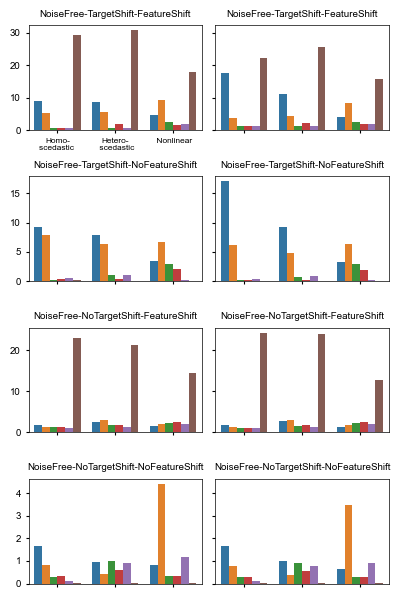

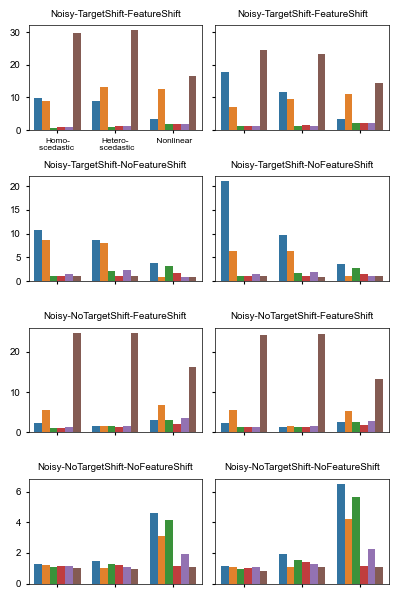

In [90]:

nsets = ["NoiseFree", "Noisy"]

for nset in nsets:
    fig, axes = plt.subplots(4, 2, figsize=(4, 6), dpi=100, sharey="row")
    subrows = list(product(
        *[["TargetShift", "NoTargetShift"], ["FeatureShift", "NoFeatureShift"]]
    ))

    for subrowix in range(4):
        subrow = subrows[subrowix]
        tset, fset = subrow
        sset = f"{nset}-{tset}-{fset}"

        for colix in range(2):
            # 0 (train) vs 1 (test)
            if colix == 0:
                df = pd.DataFrame(avg_rMSEs[sset]).T.drop(index=['Before Correction', 'Oracle'])
            else:
                df = pd.DataFrame(avg_rMSEs_test[sset]).T.drop(index=['Before Correction', 'Oracle'])
            dfmelt = df.reset_index().melt(id_vars="index")
            sns.barplot(
                data=dfmelt, x="variable", y="value", hue="index", 
                ax=axes[subrowix, colix]
            )
            axes[subrowix, colix].get_legend().remove()
            if subrowix == 0 and colix == 0:
                axes[subrowix, colix].set_xticklabels(
                    [
                        'Homo-\nscedastic ',
                        'Hetero-\n scedastic', ' Nonlinear'
                    ],
                    fontsize=6, rotation=0);
            else:
                axes[subrowix, colix].set_xticklabels(['', '', '']);
            axes[subrowix, colix].set_xlabel('');
            axes[subrowix, colix].set_ylabel('');
            axes[subrowix, colix].set_title(sset);
            """
            if subrowix in (0, 1):
                axes[subrowix, colix].set_ylim(0, 20);
            elif subrowix in (2,):
                axes[subrowix, colix].set_ylim(0, 10);
            else:
                axes[subrowix, colix].set_ylim(0, 3);
            """
        """
        if subrowix == 0 and colix == 0:
            axes[0].set_ylabel('Train RMSE', fontsize=7);
            axes[1].set_ylabel('Test RMSE', fontsize=7);
        subfigs[subrowix, subcolix].suptitle(sset);
        """
        
    plt.tight_layout();
    plt.savefig(f"figure-continuous1d-{nset}.pdf")